# Urban Growth and Vegetation Loss Analysis

This notebook analyzes the relationship between urban expansion (as captured by VIIRS Nighttime Lights) and vegetation loss (as captured by MODIS NDVI) for a selected city using remote sensing data.

**Objective:** Visualize and quantify spatial and temporal changes in NDVI and nightlights to infer urban growth patterns.

In [27]:
# Import libraries
import numpy as np
import matplotlib.pyplot as plt
import rasterio
import os
import sys
from glob import glob

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..", "src")))
from visualize import plot_ndvi_map, plot_nightlights_map
from preprocess import load_raster_as_array, calculate_difference

In [8]:
# Google Earth EngineでNDVI・VIIRSをナイロビから取得（geemap使用）
import ee
import geemap

In [10]:
# 認証・初期化（最初の一度だけ）
# Authenticate and initialize
ee.Authenticate()
ee.Initialize()

Enter verification code:  4/1AUJR-x7EhhN8FsDHCe4HvtGqpNUK87W5X4fFJ9XJRda4uaJa6nYApsjD1cI



Successfully saved authorization token.


In [33]:
# ナイロビのROI
roi = ee.Geometry.BBox(36.6, -1.5, 37.0, -1.1)

# 年と対象データ（MODIS NDVI）
def get_ndvi(year):
    return ee.ImageCollection("MODIS/006/MOD13Q1") \
        .filterDate(f"{year}-01-01", f"{year}-12-31") \
        .select("NDVI") \
        .mean() \
        .clip(roi) \
        .multiply(0.0001)  # MODISスケーリング

# VIIRS DNB
def get_viirs(year):
    return ee.ImageCollection("NOAA/VIIRS/DNB/MONTHLY_V1/VCMSLCFG") \
        .filterDate(f"{year}-01-01", f"{year}-12-31") \
        .select("avg_rad") \
        .mean() \
        .clip(roi)

# 画像取得
ndvi_2014 = get_ndvi(2014)
ndvi_2023 = get_ndvi(2023)
viirs_2014 = get_viirs(2014)
viirs_2023 = get_viirs(2023)

geemap.ee_export_image(ndvi_2014, "../data/processed/ndvi_2014.tif", scale=250, region=roi)
geemap.ee_export_image(ndvi_2023, "../data/processed/ndvi_2023.tif", scale=250, region=roi)
geemap.ee_export_image(viirs_2014, "../data/processed/viirs_2014_.tif", scale=250, region=roi)
geemap.ee_export_image(viirs_2023, "../data/processed/viirs_2023_.tif", scale=250, region=roi)

Generating URL ...
Please wait ...
Data downloaded to C:\Users\user\OneDrive\Desktop\urban-ndvi-nightlights\data\processed\ndvi_2014.tif
Generating URL ...
Please wait ...
Data downloaded to C:\Users\user\OneDrive\Desktop\urban-ndvi-nightlights\data\processed\ndvi_2023.tif
Generating URL ...
Please wait ...
Data downloaded to C:\Users\user\OneDrive\Desktop\urban-ndvi-nightlights\data\processed\viirs_2014_.tif
Generating URL ...
Please wait ...
Data downloaded to C:\Users\user\OneDrive\Desktop\urban-ndvi-nightlights\data\processed\viirs_2023_.tif


In [45]:
for year in range(2014, 2024):
    # 1) 画像取得
    ndvi_img  = get_ndvi(year)
    viirs_img = get_viirs(year)
    
    # 2) ファイル名生成
    ndvi_fname  = f"../data/processed/ndvi_{year}.tif"
    viirs_fname = f"../data/processed/viirs_{year}.tif"
    
    # 3) エクスポート
    geemap.ee_export_image(
        ndvi_img, 
        filename=ndvi_fname, 
        scale=250,        # MODIS NDVI は 250m 解像度
        region=roi
    )
    geemap.ee_export_image(
        viirs_img, 
        filename=viirs_fname, 
        scale=250,        # VIIRS 夜間光は 500m 前後
        region=roi
    )

print("All exports complete for 2014–2023.")

Generating URL ...
Please wait ...
Data downloaded to C:\Users\user\OneDrive\Desktop\urban-ndvi-nightlights\data\processed\ndvi_2014.tif
Generating URL ...
Please wait ...
Data downloaded to C:\Users\user\OneDrive\Desktop\urban-ndvi-nightlights\data\processed\viirs_2014.tif
Generating URL ...
Please wait ...
Data downloaded to C:\Users\user\OneDrive\Desktop\urban-ndvi-nightlights\data\processed\ndvi_2015.tif
Generating URL ...
Please wait ...
Data downloaded to C:\Users\user\OneDrive\Desktop\urban-ndvi-nightlights\data\processed\viirs_2015.tif
Generating URL ...
Please wait ...
Data downloaded to C:\Users\user\OneDrive\Desktop\urban-ndvi-nightlights\data\processed\ndvi_2016.tif
Generating URL ...
Please wait ...
Data downloaded to C:\Users\user\OneDrive\Desktop\urban-ndvi-nightlights\data\processed\viirs_2016.tif
Generating URL ...
Please wait ...
Data downloaded to C:\Users\user\OneDrive\Desktop\urban-ndvi-nightlights\data\processed\ndvi_2017.tif
Generating URL ...
Please wait ...
Dat

## Load Data
We assume NDVI and Nightlights GeoTIFF files have been preprocessed and saved in `data/processed/`.

In [34]:
# Load NDVI
ndvi_2014 = load_raster_as_array('../data/processed/ndvi_2014.tif')
ndvi_2023 = load_raster_as_array('../data/processed/ndvi_2023.tif')

# Load Nightlights
viirs_2014 = load_raster_as_array('../data/processed/viirs_2014_.tif')
viirs_2023 = load_raster_as_array('../data/processed/viirs_2023_.tif')

## Visualize Spatial Patterns

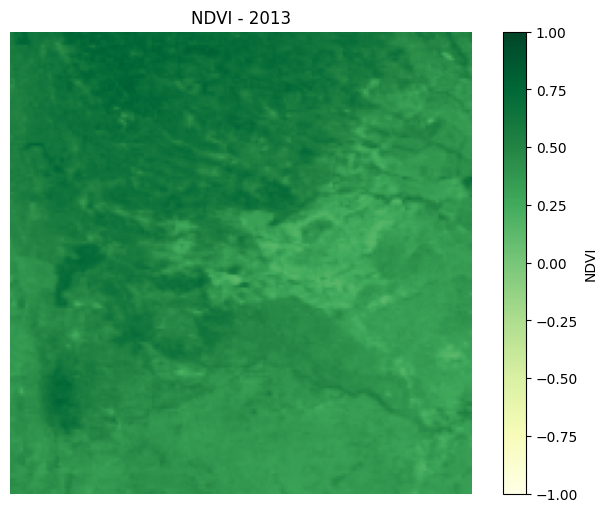

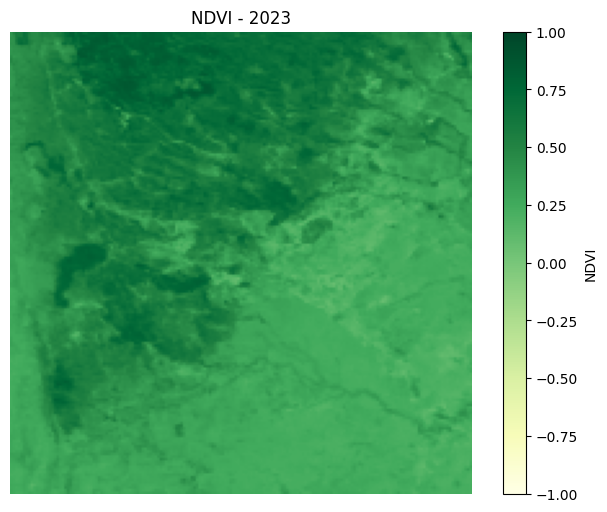

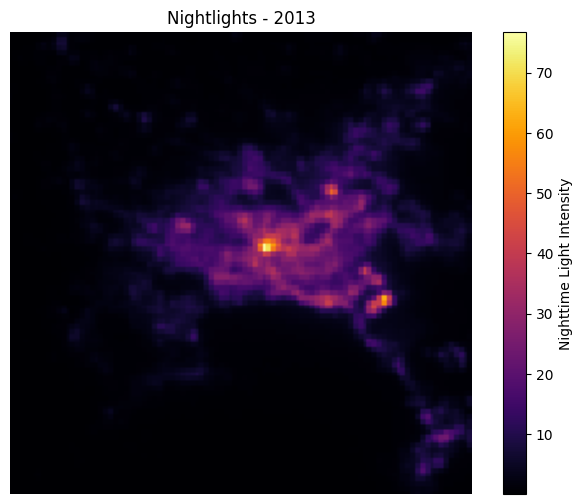

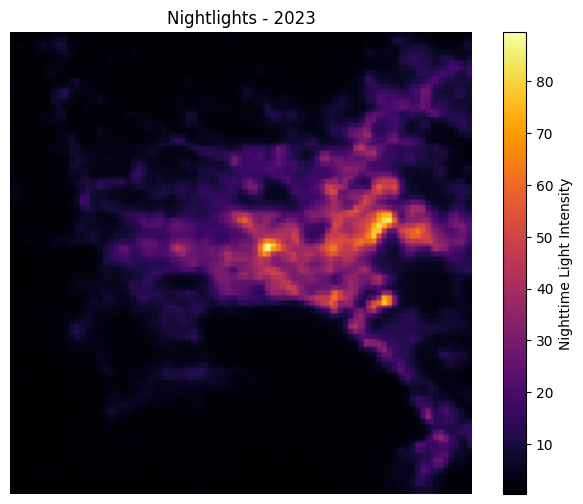

In [35]:
# Plot NDVI maps
plot_ndvi_map(ndvi_2014, title='NDVI - 2013')
plot_ndvi_map(ndvi_2023, title='NDVI - 2023')

# Plot Nightlights maps
plot_nightlights_map(viirs_2014, title='Nightlights - 2013')
plot_nightlights_map(viirs_2023, title='Nightlights - 2023')

## Compute Difference Maps

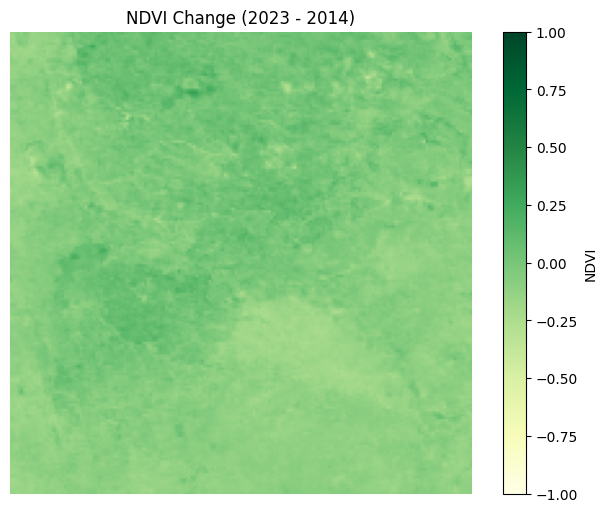

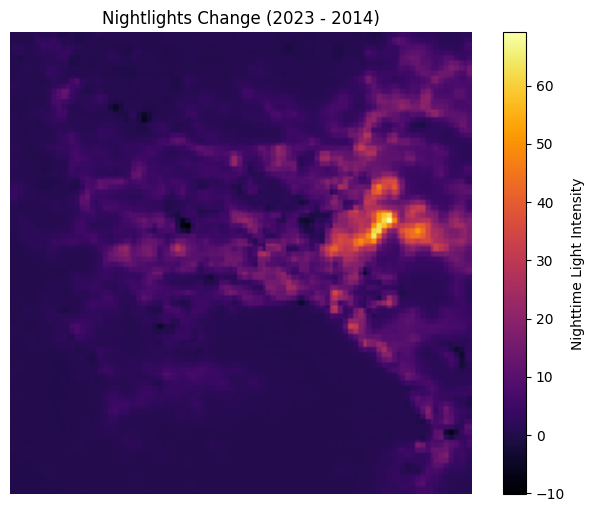

In [36]:
ndvi_diff = calculate_difference(ndvi_2023, ndvi_2014)
viirs_diff = calculate_difference(viirs_2023, viirs_2014)

plot_ndvi_map(ndvi_diff, title='NDVI Change (2023 - 2014)')
plot_nightlights_map(viirs_diff, title='Nightlights Change (2023 - 2014)')

## NDVI低下量 vs. 夜間光増加量で回帰
1. 差分ラスタ（viirs_diff, ndvi_diff）を flatten() で 1 次元に。
2. NaN マスクで有効画素だけ抽出。
3. LinearRegression で単回帰 → 係数・R² を出力。
4. 必要なら statsmodels で詳細な統計量（標準誤差・p 値など）を確認。
5. 散布図＋回帰線で視覚化。

Slope       : -0.0004
Intercept   : 0.0542
R²          : 0.0010
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     31.96
Date:                Sun, 22 Jun 2025   Prob (F-statistic):           1.59e-08
Time:                        10:08:46   Log-Likelihood:                 37092.
No. Observations:               32041   AIC:                        -7.418e+04
Df Residuals:                   32039   BIC:                        -7.416e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------

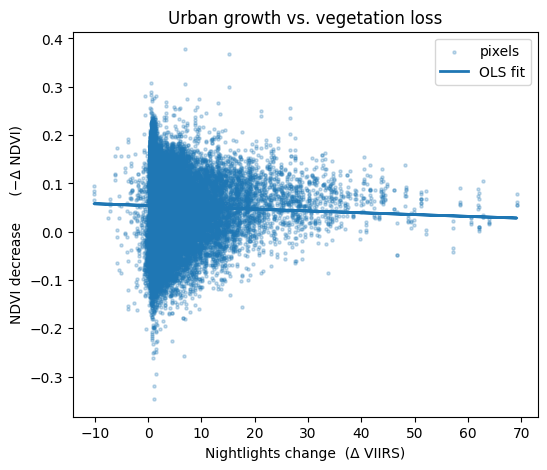

In [37]:
# -----------------------------------------------------------
# NDVI 低下量（-ΔNDVI） vs. 夜間光増加量 (ΔVIIRS) の単回帰
# -----------------------------------------------------------
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import statsmodels.api as sm  # 参考用（詳細出力したい場合）

# 1) 解析用ベクトルに変換（flatten）し NaN を除外
x_raw = viirs_diff.flatten()                 # ΔNightlights
y_raw = -ndvi_diff.flatten()                 # NDVI 低下量 = -ΔNDVI

mask = (~np.isnan(x_raw)) & (~np.isnan(y_raw))
X = x_raw[mask].reshape(-1, 1)               # scikit-learn 用に 2D に
y = y_raw[mask]

# 2) scikit-learn で OLS
model = LinearRegression()
model.fit(X, y)
y_hat = model.predict(X)

print(f"Slope       : {model.coef_[0]:.4f}")
print(f"Intercept   : {model.intercept_:.4f}")
print(f"R²          : {r2_score(y, y_hat):.4f}")

# 3) （任意）statsmodels で回帰サマリを確認
X_sm = sm.add_constant(X)                    # 定数項を追加
ols = sm.OLS(y, X_sm).fit()
print(ols.summary())

# 4) 散布図と回帰直線
plt.figure(figsize=(6, 5))
plt.scatter(X, y, s=5, alpha=0.25, label="pixels")
plt.plot(X, y_hat, linewidth=2, label="OLS fit")
plt.xlabel("Nightlights change  (Δ VIIRS)")
plt.ylabel("NDVI decrease      (−Δ NDVI)")
plt.title("Urban growth vs. vegetation loss")
plt.legend()
plt.show()

In [32]:
import numpy as np
import rasterio
from rasterio.warp import reproject, Resampling

# 1) 差分ラスタを読み込み
ndvi_diff_orig = rasterio.open('../data/processed/ndvi_2023.tif').read(1) \
                - rasterio.open('../data/processed/ndvi_2014.tif').read(1)
viirs_diff     = rasterio.open('../data/processed/viirs_2023.tif').read(1) \
                - rasterio.open('../data/processed/viirs_2014.tif').read(1)

# 2) VIIRS のメタデータを参照
with rasterio.open('../data/processed/viirs_2023.tif') as ref:
    ref_transform = ref.transform
    ref_crs       = ref.crs
    height, width = ref.height, ref.width

# 3) 空の配列を用意し、NDVIをリサンプリング
ndvi_resampled = np.empty((height, width), dtype=np.float32)

with rasterio.open('../data/processed/ndvi_2023.tif') as src:
    reproject(
        source=ndvi_diff_orig,
        destination=ndvi_resampled,
        src_transform=src.transform,
        src_crs=src.crs,
        dst_transform=ref_transform,
        dst_crs=ref_crs,
        resampling=Resampling.bilinear
    )

# 4) フラット化して NaN マスク
x_raw = viirs_diff.flatten()                # ΔNightlights
y_raw = -ndvi_resampled.flatten()           # −ΔNDVI（植生損失）

mask  = (~np.isnan(x_raw)) & (~np.isnan(y_raw))
X     = x_raw[mask].reshape(-1, 1)
y     = y_raw[mask]

# 5) 単回帰
from sklearn.linear_model import LinearRegression
from sklearn.metrics     import r2_score

model = LinearRegression().fit(X, y)
print("Slope:",     model.coef_[0])
print("Intercept:", model.intercept_)
print("R²:",        r2_score(y, model.predict(X)))


Slope: -0.0003717678
Intercept: 0.052831106
R²: 0.0011061429977416992


## RGBコンポジットマップ(「ホットスポット」を一目で把握)と六角ビン図（「全体傾向」と「密度分布」を同時に示す）

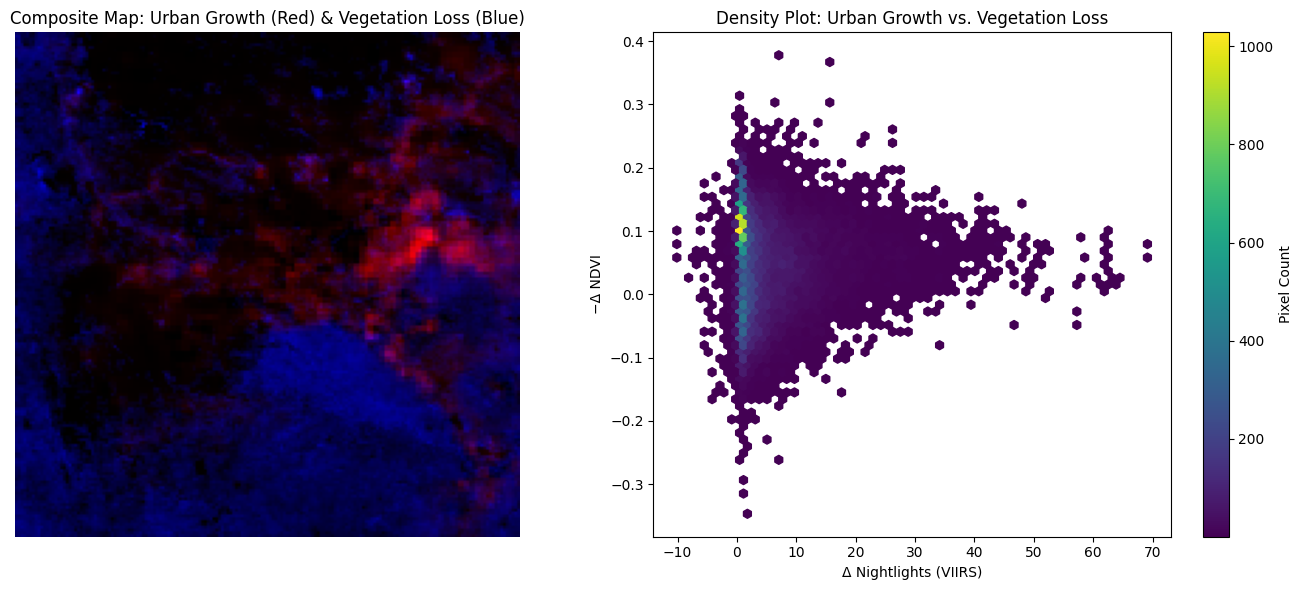

In [38]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt

# Load preprocessed difference GeoTIFFs
ndvi_diff = rasterio.open('../data/processed/ndvi_2023.tif').read(1) - rasterio.open('../data/processed/ndvi_2014.tif').read(1)
viirs_diff = rasterio.open('../data/processed/viirs_2023_.tif').read(1) - rasterio.open('../data/processed/viirs_2014_.tif').read(1)

# Normalize for composite visualization
ndvi_loss = np.clip(-ndvi_diff, 0, None)  # vegetation loss
viirs_gain = np.clip(viirs_diff, 0, None)  # urban growth proxy

# Avoid division by zero
if ndvi_loss.max() > 0:
    ndvi_norm = ndvi_loss / ndvi_loss.max()
else:
    ndvi_norm = ndvi_loss
if viirs_gain.max() > 0:
    viirs_norm = viirs_gain / viirs_gain.max()
else:
    viirs_norm = viirs_gain

# Create RGB composite: red = viirs_norm, blue = ndvi_norm
rgb = np.zeros((ndvi_norm.shape[0], ndvi_norm.shape[1], 3), dtype=float)
rgb[..., 0] = viirs_norm
rgb[..., 2] = ndvi_norm

# Prepare scatter data
x = viirs_diff.flatten()
y = -ndvi_diff.flatten()
mask = (~np.isnan(x)) & (~np.isnan(y))

# Plot composite map and density hexbin side-by-side
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# Composite map
axs[0].imshow(rgb)
axs[0].axis('off')
axs[0].set_title('Composite Map: Urban Growth (Red) & Vegetation Loss (Blue)')

# Hexbin scatter
hb = axs[1].hexbin(x[mask], y[mask], gridsize=60, mincnt=1)
axs[1].set_xlabel('Δ Nightlights (VIIRS)')
axs[1].set_ylabel('−Δ NDVI')
axs[1].set_title('Density Plot: Urban Growth vs. Vegetation Loss')
fig.colorbar(hb, ax=axs[1], label='Pixel Count')

plt.tight_layout()
plt.savefig('../outputs/composite_map_and_density_plot.png')
plt.show()


左が「都市拡大（赤）と植生損失（青）」を同時に可視化したRGBコンポジットマップ、右がピクセル密度を可視化した六角ビン散布図
- RGBコンポジット
  * 赤チャネル：夜間光増加量（VIIRS Δ）
  * 青チャネル：NDVI低下量（−Δ NDVI）
  * マジェンタに見える場所は、両方の値が高い「都市拡大と植生損失が重なるホットスポット」です。

- 六角ビン散布図
  * 各ビンの色は、その範囲に含まれるピクセル数に応じた密度を示す。
  * 対話的・視覚的に「どの範囲にピクセルが集まっているか」がわかりやすいのが特徴。

## ローカルモラント検定によるクラスターマップ

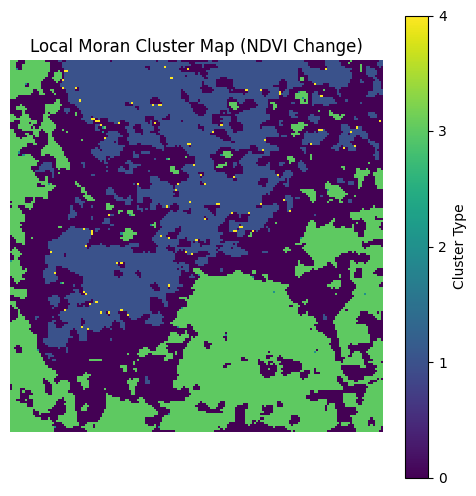

In [39]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt

# 空間統計用ライブラリ
from libpysal.weights import lat2W
from esda import Moran_Local
import mapclassify

# 1) 差分ラスタの読み込み
ndvi_diff = rasterio.open('../data/processed/ndvi_2023.tif').read(1) - rasterio.open('../data/processed/ndvi_2014.tif').read(1)

# 2) 欠損値をマスクして 1D 配列化
mask = ~np.isnan(ndvi_diff)
y = ndvi_diff[mask]

# 3) 空間重み行列作成（近傍 8 近傍格子）
h, w = ndvi_diff.shape
wghts = lat2W(h, w, rook=False)  # queen (8近傍)

# 4) ローカルモラント算出
mi = Moran_Local(y, wghts, transformation='r', permutations=999)

# 5) クラス分類（high–high, low–low, high–low, low–high）
sig = 1 * (mi.p_sim < 0.05)
quad = mi.q
# 0: 非有意, 1: HH, 2: LH, 3: LL, 4: HL
cluster = np.full(y.shape, 0)
cluster[(quad==1)&(sig==1)] = 1
cluster[(quad==2)&(sig==1)] = 4
cluster[(quad==3)&(sig==1)] = 3
cluster[(quad==4)&(sig==1)] = 2

# 6) 元のグリッドに戻す
cluster_map = np.full(ndvi_diff.shape, 0)
cluster_map[mask] = cluster

# 7) プロット
plt.figure(figsize=(6,6))
plt.imshow(cluster_map, interpolation='nearest')
plt.colorbar(ticks=[0,1,2,3,4], label='Cluster Type')
plt.clim(0,4)
plt.title('Local Moran Cluster Map (NDVI Change)')
plt.axis('off')
plt.savefig('../outputs/moran_cluster_map.png')
plt.show()


凡例
- 0: 非有意
- 1: High–High（大きな減少が周辺と共に集積）
- 2: High–Low（大きな減少が周辺は増加）
- 3: Low–Low（小さな変化が集積）
- 4: Low–High（小さな変化が周辺は大きく変化）

## 時系列アニメーション GIF の生成

In [43]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
import imageio
import os

years = list(range(2014, 2024))
frames = []

for yr in years:
    arr = rasterio.open(f'../data/processed/ndvi_{yr}.tif').read(1)
    # 正規化
    arr_norm = (arr - np.nanmin(arr)) / (np.nanmax(arr) - np.nanmin(arr))
    
    # プロット画像を一時保存
    fig, ax = plt.subplots(figsize=(4,4))
    img = ax.imshow(arr_norm, vmin=0, vmax=1)
    ax.set_title(f'NDVI {yr}')
    ax.axis('off')
    plt.tight_layout()
    
    tmpfile = f'_tmp_{yr}.png'
    fig.savefig(tmpfile, dpi=100)
    plt.close(fig)
    
    frames.append(imageio.imread(tmpfile))
    os.remove(tmpfile)

# GIF 保存
imageio.mimsave('../outputs/ndvi_timeseries.gif', frames, duration=10.0, loop=0)
print("生成完了: ndvi_timeseries.gif")


C:\Users\user\AppData\Local\Temp\ipykernel_8336\1669539215.py:26: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  frames.append(imageio.imread(tmpfile))


生成完了: ndvi_timeseries.gif


In [51]:
import rasterio
import numpy as np
import imageio
import matplotlib.pyplot as plt
import os

frames = []
years = list(range(2015, 2024))

for year in years:
    # 差分読み込み（前年⇔当年）
    ndvi_prev  = rasterio.open(f'../data/processed/ndvi_{year-1}.tif').read(1)
    ndvi_curr  = rasterio.open(f'../data/processed/ndvi_{year}.tif').read(1)
    viirs_prev = rasterio.open(f'../data/processed/viirs_{year-1}.tif').read(1)
    viirs_curr = rasterio.open(f'../data/processed/viirs_{year}.tif').read(1)
    
    ndvi_diff  = ndvi_curr  - ndvi_prev
    viirs_diff = viirs_curr - viirs_prev
    
    veg_loss = np.clip(-ndvi_diff, 0, None)
    urb_gain = np.clip(viirs_diff, 0, None)
    veg_norm = veg_loss / veg_loss.max() if veg_loss.max()>0 else veg_loss
    urb_norm = urb_gain / urb_gain.max() if urb_gain.max()>0 else urb_gain

    rgb = np.zeros((veg_norm.shape[0], veg_norm.shape[1], 3), dtype=np.uint8)
    rgb[..., 0] = (urb_norm * 255).astype(np.uint8)
    rgb[..., 2] = (veg_norm * 255).astype(np.uint8)

    # タイトル付きフレームを描画
    fig, ax = plt.subplots(figsize=(6, 6), facecolor='black')
    ax.imshow(rgb)
    ax.set_title(f"{year-1} → {year}",
                 fontsize=18, color='white',
                 pad=12, backgroundcolor='black')
    ax.axis('off')
    
    # print_to_buffer で RGBA バッファを取得
    buf, (w, h) = fig.canvas.print_to_buffer()
    plt.close(fig)
    
    # バッファを numpy 配列化し、RGBA→RGB
    frame = np.frombuffer(buf, dtype=np.uint8).reshape(h, w, 4)[..., :3]
    frames.append(frame)

# GIF 保存
imageio.mimsave(
    '../outputs/composite_diff_2014_2023_title.gif',
    frames,
    fps=0.5,
    loop=0
)

print("GIF を生成しました: ../outputs/composite_diff_2014_2023_title.gif")


GIF を生成しました: ../outputs/composite_diff_2014_2023_title.gif


In [52]:
import os
import numpy as np
import rasterio
import matplotlib.pyplot as plt
import imageio

from libpysal.weights import lat2W
from esda import Moran_Local

frames = []
years = list(range(2015, 2024))

for year in years:
    # ── 1. 差分ラスタ読み込み ─────────────────────────────────
    ndvi_prev = rasterio.open(f'../data/processed/ndvi_{year-1}.tif').read(1)
    ndvi_curr = rasterio.open(f'../data/processed/ndvi_{year}.tif').read(1)
    diff      = ndvi_curr - ndvi_prev

    # ── 2. 有効画素マスク＆1D化 ────────────────────────────────
    mask = ~np.isnan(diff)
    y    = diff[mask]

    # ── 3. 空間重み行列（グリッド 8 近傍）────────────────────
    h, w     = diff.shape
    wghts    = lat2W(h, w, rook=False)    # queen (8近傍)

    # ── 4. ローカルモラント検定────────────────────────────────
    mi       = Moran_Local(y, wghts, transformation='r', permutations=499)
    sig      = (mi.p_sim < 0.05).astype(int)
    quad     = mi.q
    # クラスタ識別：0=非有意, 1=HH, 2=HL, 3=LL, 4=LH
    cluster1d = np.zeros_like(y, dtype=int)
    cluster1d[(quad==1)&(sig==1)] = 1
    cluster1d[(quad==2)&(sig==1)] = 4
    cluster1d[(quad==3)&(sig==1)] = 3
    cluster1d[(quad==4)&(sig==1)] = 2

    # 元のマトリクスに戻す
    cluster_map = np.zeros(diff.shape, dtype=int)
    cluster_map[mask] = cluster1d

    # ── 5. フレーム作成 ─────────────────────────────────────
    fig, ax = plt.subplots(figsize=(6, 6), facecolor='white')
    cmap = plt.get_cmap('tab10', 5)
    im   = ax.imshow(cluster_map, cmap=cmap, vmin=0, vmax=4)
    ax.set_title(f"Local Moran Clusters\n{year-1} → {year}", fontsize=16, pad=10)
    ax.axis('off')

    # カラーバー
    cbar = fig.colorbar(im, ticks=[0,1,2,3,4], shrink=0.8)
    cbar.ax.set_yticklabels([
        'Not significant', 
        'High–High', 
        'Low–High', 
        'Low–Low', 
        'High–Low'
    ])

    # バッファ取得
    buf, (w_fig, h_fig) = fig.canvas.print_to_buffer()
    plt.close(fig)
    frame = np.frombuffer(buf, dtype=np.uint8).reshape(h_fig, w_fig, 4)[..., :3]
    frames.append(frame)

# ── 6. GIF として保存 ────────────────────────────────────
imageio.mimsave(
    '../outputs/cluster_diff_2014_2023.gif',
    frames,
    fps=0.5,  # 各フレーム2秒表示
    loop=0         # 無限ループ
)

print("GIF 完成: ../outputs/cluster_diff_2014_2023.gif")


GIF 完成: ../outputs/cluster_diff_2014_2023.gif
